<a href="https://colab.research.google.com/github/YoungriKIM/1D-Speech-Emotion-Recognition/blob/master/colab_emodata1d_modify_for_2d_independent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
# 지대 짱나는 코랩쓰기~
# from google.colab import drive
# drive.mount('/content/gdrive')

In [114]:
# 화자 독립으로 돌리기 전에 종속으로 돌리는 파일
# test 이름 뽑고 싶어서 수정하는 파일
# use raw time-domain speech signal as input to cnn for SER

import numpy as np
import os
import librosa

In [115]:
datapath_tr = '/content/drive/MyDrive/YESPEECH/SER/data/berlin/train/'
datapath_v = '/content/drive/MyDrive/YESPEECH/SER/data/berlin/val/'
datapath_t = '/content/drive/MyDrive/YESPEECH/SER/data/berlin/test/'
classes = ['W','L','E','A','F','T','N'] # 7 classes

seg_len = 16000*8
# signal split length (in samples) in time domain
# 8초로 하기 위해 *8 해줌
seg_ov = int(seg_len*0.5) # 50% overlap
# 데이터가 8초보다 길 때 중첩할 비율

# 오디오 정규화, 길이에 영향 안 줌
def normalize(s):
# RMS normalization
   new_s = s/np.sqrt(np.sum(np.square((np.abs(s))))/len(s))
   return new_s

# 라벨 각 몇개인지 세는 함수
def countclasses(fnames):
   dict = {classes[0]:0,classes[1]:0,classes[2]:0,classes[3]:0,classes[4]:0,classes[5]:0,classes[6]:0}
   for name in fnames:
      if name[5] in classes:
         dict[name[5]]+=1
   return dict

# 데이터 만들기
def make_data(path):
    fnames = os.listdir(path)
    dict = countclasses(fnames)
    print('Total Data',dict)
    num_cl = len(classes)
    data_dict = {classes[0]:0,classes[1]:0,classes[2]:0,classes[3]:0,classes[4]:0,classes[5]:0,classes[6]:0}

    x = []
    y = []
    y_name = []

    sr = 16000
    n_fft = 2048
    hop_length = 512

    count = {classes[0]:0,classes[1]:0,classes[2]:0,classes[3]:0,classes[4]:0,classes[5]:0,classes[6]:0}

    for name in fnames:
        if name[5] in classes:
            sig,fs = librosa.load(datapath+'/'+name, sr=sr)
            # normalize signal
            data = normalize(sig)

            # 오디오 시그널이 지정한 길이 보다 짧을 때는 오른쪽에 제로패딩
            if(len(data) < seg_len):
                pad_right = int(seg_len-len(data))
                signal = np.pad(data,(0, pad_right),'constant',constant_values=0)
                mels = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)
                mels = librosa.power_to_db(mels, ref=np.max)
                # print('짧을 때:', len(signal))

            # 길 때는 지정한 길이 만큼만 잘라서 넣기(임시작업중)
            elif(len(data) > seg_len):
                signal = data[:seg_len]
                mels = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)
                mels = librosa.power_to_db(mels, ref=np.max)
                # print('길 때:', len(signal))

            # 같다면 데이터 그대로 적용
            else:
                signal = data
                mels = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)
                mels = librosa.power_to_db(mels, ref=np.max)
                # print('같을 때:', len(signal))

            x.append(mels)
            y.append(name[5])
            y_name.append(name)

        count[name[5]]+=1   
    return np.float32(x),y,y_name

In [126]:
def string2num(y):
   y1 = []
   for i in y:
      if(i == classes[0]):
         y1.append(0)
      elif(i == classes[1]):
         y1.append(1)
      elif(i == classes[2]):
         y1.append(2)
      elif(i == classes[3]):
         y1.append(3)
      elif(i == classes[4]):
         y1.append(4)
      elif(i == classes[5]):
         y1.append(5)
      else:
         y1.append(6)
   y1 = np.float32(np.array(y1))
   return y1

def load_data():
       
    x_tr, y_tr, y_tr_n = make_data(datapath_tr)
    x_v, y_v, y_v_n = make_data(datapath_v)
    x_t, y_t, y_t_n = make_data(datapath_t)

    x_tr = np.array(x_tr)
    x_v = np.array(x_v)
    x_t = np.array(x_t)

    x_tr = x_tr.reshape(x_tr.shape[0], x_tr.shape[1], x_tr.shape[2], 1)
    x_v = x_v.reshape(x_v.shape[0], x_v.shape[1], x_v.shape[2], 1)
    x_t = x_t.reshape(x_t.shape[0], x_t.shape[1], x_t.shape[2], 1)

    y_tr = string2num(y_tr)
    y_v = string2num(y_v)
    y_t = string2num(y_t)

    print(x_tr.shape,y_tr.shape)
    print(x_v.shape,y_v.shape)
    print(x_t.shape,y_t.shape)

    return x_tr, y_tr, x_v, y_v, x_t, y_t

In [117]:
# 데이터 확인용

# train -----------------------------------------------------------
print('*'*20,' test ')
x_tr, y_tr, y_tr_n = make_data(datapath_tr)
print(x_tr.shape, len(y_tr)) # (363, 128, 251) 363

print('y_tr_n 의 화자: ', end='');check_act(y_tr_n)
# y_tr_n 의 화자: ['03', '08', '09', '10', '12', '16', '14']
# val -----------------------------------------------------------
print('*'*20,' test ')
x_v, y_v, y_v_n = make_data(datapath_v)
print(x_v.shape, len(y_v_n)) # (56, 128, 251) 56

print('y_v_n 의 화자: ', end='');check_act(y_v_n)
# y_v_n 의 화자: ['15']
# test -----------------------------------------------------------
print('*'*20,' test ')
x_t, y_t, y_t_n = make_data(datapath_t)
print(x_t.shape, len(y_t)) # (116, 128, 251) 116

print('y_t_n 의 화자: ', end='');check_act(y_t_n)
# y_t_n 의 화자: ['11', '13']

********************  test 
Total Data {'W': 91, 'L': 54, 'E': 31, 'A': 44, 'F': 47, 'T': 46, 'N': 50}
(363, 128, 251) 363
y_tr_n 의 화자: ['03', '08', '09', '10', '12', '16', '14']
********************  test 
Total Data {'W': 13, 'L': 9, 'E': 5, 'A': 8, 'F': 6, 'T': 4, 'N': 11}
(56, 128, 251) 56
y_v_n 의 화자: ['15']
********************  test 
Total Data {'W': 23, 'L': 18, 'E': 10, 'A': 17, 'F': 18, 'T': 12, 'N': 18}
(116, 128, 251) 116
y_t_n 의 화자: ['11', '13']


In [118]:
# !pip install keras-self-attention
from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, LSTM, Dense, Activation, Layer
from keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, LeakyReLU
from tensorflow.python.ops.array_ops import sequence_mask
# from emodata1d import load_data
# from emodata1d_modify_for_2d import load_data
from tensorflow.keras.utils import to_categorical
import keras.backend as K
import argparse
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import load_model
from keras_self_attention import SeqSelfAttention
# self attention 참고: https://pypi.org/project/keras-self-attention/
import datetime

In [119]:
def emo2d(input_shape, num_classes, lr):
    model = Sequential(name='Emo2D')

    # LFLB1
    model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), padding='same', data_format='channels_last',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # LFLB2
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3)))

    # LFLB3
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3)))

    # LFLB4
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))

    # LSTM
    model.add(Flatten())
    model.add(Reshape((1,384)))
    model.add(LSTM(256 ,return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='tanh'))
    model.add(LSTM(64))

    # # FC
    # model.add(Flatten())
    model.add(Dense(units=num_classes, activation='softmax'))

    # Model compilation
    # opt = optimizers.SGD(lr=args.learning_rate, decay=args.decay, momentum=args.momentum, nesterov=True)
    # opt = optimizers.RMSprop(lr=args.learning_rate)#, decay=args.decay, momentum=args.momentum)
    # opt = optimizers.Adagrad(lr=args.learning_rate)#, decay=args.decay, momentum=args.momentum)
    opt = optimizers.Adam(lr=lr)#, decay=args.decay, momentum=args.momentum)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [128]:
h5_path = '/content/drive/MyDrive/yespeechdata/h5/best_model_51.h5'

def train(model, x_tr, y_tr, x_val, y_val, epochs, batch_size):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=16)
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, mode='min')
    mc = ModelCheckpoint(filepath=h5_path, monitor='val_loss', mode='min', verbose=1,
                         save_best_only=True)
    # tb = TensorBoard(log_dir='D:/yespeechdata/graph/' + h5_path.split('/')[-1][:-3] + "/",histogram_freq=0, write_graph=True, write_images=True)
    
    history = model.fit(x_tr, y_tr, epochs=num_epochs, batch_size=num_batch_size, validation_data=(x_val, y_val),
                        callbacks=[es, mc, lr])

    print('loss : ', history.history['loss'][-1])
    print('acc : ', history.history['accuracy'][-1])
    print('val loss : ', history.history['val_loss'][-1])
    print('val acc : ', history.history['val_accuracy'][-1])
    return model

def test(model, x_t, y_t):
    saved_model = load_model(model, custom_objects={'SeqSelfAttention':SeqSelfAttention})
    score = saved_model.evaluate(x_t, y_t, batch_size=16)
    print('test loss : ', score[0])
    print('test acc : ', score[1])

    return score

In [124]:
def loadData():
    x_tr, y_tr, x_v, y_v, x_t, y_t = load_data()
    y_tr = to_categorical(y_tr)
    y_t = to_categorical(y_t)
    y_v = to_categorical(y_v)
    return x_tr, y_tr, x_v, y_v, x_t, y_t

def cf_make(cf_matrix):
    
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    # 시각화
    categories = ['anger','boredom', 'disgust', 'anxiety/fear', 'happiness', 'sadness', 'neutral']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = []
    for i in cf_matrix:
        group_percentage = ["{0:.2%}".format(value) for value in i.flatten()/np.sum(i)]
        group_percentages.append(group_percentage)
    
    group_percentageslist = sum(group_percentages, [])

    # average acc 구하기 -------------------
    sumcm = 0
    cate = cf_matrix.shape[0]
    for j in range(cate):
        for k in range(cate):
            if j == k:
                thenum = group_percentages[j][k]
                sumcm += float(thenum[:-1])
                aveacc = sumcm/cate
    print('average acc: ', round(aveacc, 2),'%')
    # -------------------------------------
    # 시각화 이어서 진행
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentageslist)]
    labels = np.asarray(labels).reshape(7,7)
    plt.subplots(figsize=(10,6))
    plt.title('confusion_matrix')
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.show()

Total Data {'W': 91, 'L': 54, 'E': 31, 'A': 44, 'F': 47, 'T': 46, 'N': 50}
Total Data {'W': 13, 'L': 9, 'E': 5, 'A': 8, 'F': 6, 'T': 4, 'N': 11}
Total Data {'W': 23, 'L': 18, 'E': 10, 'A': 17, 'F': 18, 'T': 12, 'N': 18}
(363, 128, 251, 1) (363,)
(56, 128, 251, 1) (56,)
(116, 128, 251, 1) (116,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1500
12/12 [==============================] - 6s 183ms/step - loss: 1.9313 - accuracy: 0.2476 - val_loss: 1.9395 - val_accuracy: 0.2321

Epoch 00001: val_loss improved from inf to 1.93949, saving model to /content/drive/MyDrive/yespeechdata/h5/best_model_51.h5
Epoch 2/1500
12/12 [==============================] - 1s 62ms/step - loss: 1.8601 - accuracy: 0.2765 - val_loss: 1.9418 - val_accuracy: 0.2321

Epoch 00002: val_loss did not improve from 1.93949
Epoch 3/1500
12/12 [==============================] - 1s 62ms/step - loss: 1.7822 - accuracy: 0.3128 - val_loss: 1.9478 - val_accuracy: 0.2321

Epoch 00003: val_loss did not improve from 1.93949
Epoch 4/1500
12/12 [==============================] - 1s 63ms/step - loss: 1.7247 - accuracy: 0.3584 - val_loss: 1.9544 - val_accuracy: 0.2321

Epoch 00004: val_loss did not improve from 1.93949
Epoch 5/1500
12/12 [==============================] - 1s 63ms/step - loss: 1.6002 - accuracy: 0.4591 - val_loss: 1.9702 - val_accuracy: 0.2321

Ep

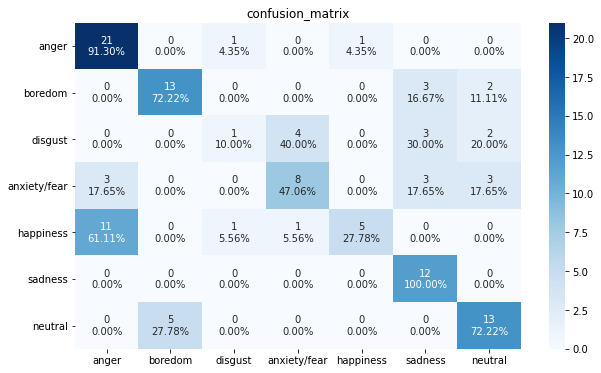

모델 학습이 완료되었습니다.
tim:  0:01:42.461649


In [129]:
# 시간 측정
str_time = datetime.datetime.now()

# if __name__ == "__main__":
#     import numpy as np
#     import matplotlib.pyplot as plt

# parser = argparse.ArgumentParser()
# args = parser.parse_args()

# load data
x_tr, y_tr, x_val, y_val, x_t, y_t= loadData()

num_batch_size = 32
num_epochs = 1500  # best model will be saved before number of epochs reach this value
# args.learning_rate = 0.0001
learning_rate = 0.0001

# define model
model = emo2d(input_shape=x_tr.shape[1:], num_classes=len(np.unique(np.argmax(y_tr, 1))), lr = learning_rate)
# model.summary()

# train model
model = train(model, x_tr, y_tr, x_val, y_val, num_epochs, num_batch_size)

# test model
score = test(h5_path, x_t, y_t) #[0.9742442428736396, 0.6445672231594283]

# predict model
saved_model = load_model(h5_path, custom_objects={'SeqSelfAttention':SeqSelfAttention})
y_p = saved_model.predict(x_t)
y_p = np.argmax(y_p, axis=1)
y_t = np.argmax(y_t, axis=1)
cf_matrix = confusion_matrix(y_t, y_p)

cf_make(cf_matrix)


# 시간 측정
print('모델 학습이 완료되었습니다.')
print('tim: ', datetime.datetime.now() - str_time)